In [121]:
import tensorflow as tf
import random
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score,r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, log_loss
import numpy as np

In [117]:
def load_data(path: str, target_map: dict, criteria_nr: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Preprocesses the data for training a machine learning model.

    Args:
        path (str): The path to the CSV file containing the data.
        target_map (dict): A dictionary mapping target values to binary labels.
        criteria_nr (int): The number of criteria used for classification.

    Returns:
        tuple: A tuple containing the preprocessed data and the train-test split.
    """
    # Read the data from the CSV file
    data = pd.read_csv(path, header=None)

    # Apply the target mapping to convert target values to binary labels
    data[criteria_nr] = data[criteria_nr].apply(lambda x: target_map[x])

    # Remove duplicate rows from the data
    data = data.drop_duplicates()

    # Split the data into input features and target variable
    data_input = data.iloc[:, :criteria_nr].values
    data_target = data[criteria_nr].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        data_input, data_target, test_size=0.2, random_state=1234
    )

    return (X_train, X_test, y_train, y_test)

In [118]:
target_map = {0: 0, 1: 1}
criteria_nr = 5
X_train, X_test, y_train, y_test=load_data('mammographic.csv',target_map,criteria_nr)

In [119]:
nn=tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units=32,activation='relu'))
nn.add(tf.keras.layers.Dense(units=16,activation='relu'))
nn.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
nn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'] )

## Model Training and Testing

In [120]:
class TestMetricsCallback(Callback):
    #callback class used to gather metrics on the test set during training
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.test_loss = []
        self.test_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_prob = self.model.predict(self.X_test, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype("int32")

        loss = log_loss(self.y_test, y_pred_prob)
        acc = accuracy_score(self.y_test, y_pred)

        self.test_loss.append(loss)
        self.test_accuracy.append(acc)
        print(f"Epoch {epoch+1}: Test loss={loss:.4f}, acc={acc:.4f}")


In [84]:
#training the model
test_callback = TestMetricsCallback(X_test, y_test)
history=nn.fit(X_train,y_train,batch_size=16,epochs=100,callbacks=[test_callback])

Epoch 1/100
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5126 - loss: 0.7171Epoch 1: Test loss=0.6818, acc=0.6903
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5095 - loss: 0.7142
Epoch 2/100
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6870 - loss: 0.6767  Epoch 2: Test loss=0.6464, acc=0.7345
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6854 - loss: 0.6755
Epoch 3/100
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6780 - loss: 0.6557  Epoch 3: Test loss=0.6191, acc=0.7434
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6839 - loss: 0.6533
Epoch 4/100
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7242 - loss: 0.6245 Epoch 4: Test loss=0.5972, acc=0.7611
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7208 - loss: 0.6264
Epoch 5/100
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6811 - loss: 0.6345 Epoch 5: Test loss=0.5809, acc=0.7611
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6926 - loss: 0.6284
Epoch 6/100
13/29 

In [85]:
nn.load_weights("model.weights.h5")

In [122]:
def plot_history_with_test(history, test_callback):
    # Training metrics from history
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']

    # Test metrics from callback
    test_loss = test_callback.test_loss
    test_acc = test_callback.test_accuracy

    epochs = range(1, len(train_loss) + 1)

    for metric_name, train_metric, test_metric in zip(['Loss', 'Accuracy'],[train_loss, train_acc],[test_loss, test_acc]):
        plt.figure()
        plt.plot(epochs, train_metric, label='Train')
        plt.plot(epochs, test_metric, label='Test')
        plt.title(metric_name)
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid(True)
        plt.show()

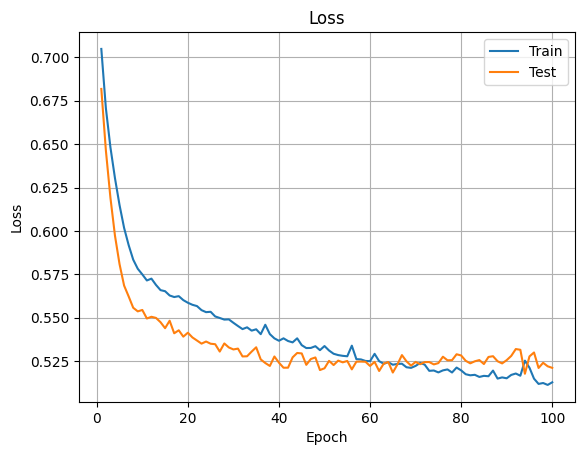

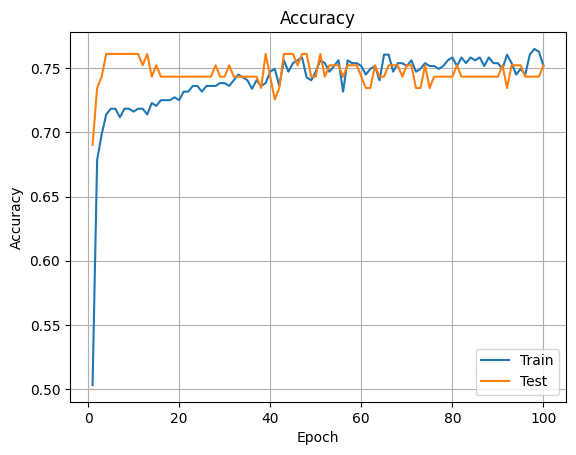

In [87]:
plot_history_with_test(history, test_callback)

In [88]:
metrics=nn.evaluate(X_test,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7467 - loss: 0.5372 


In [89]:
y_pred=nn.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [90]:
y_pred=(y_pred>0.5).astype('int32')

In [91]:
loss,accuracy=metrics

In [92]:
f1=f1_score(y_test,y_pred)

### Metrics on the test set for the trained model

In [93]:
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, F1 score: {f1:.4f}")

Loss: 0.5048, Accuracy: 0.7522, F1 score: 0.7627


## Model visualization
We will use a small neural network with three layers, first two having ReLU activation function and the output layer having sigmoid activation.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,213 (8.65 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,476 (5.77 KB)

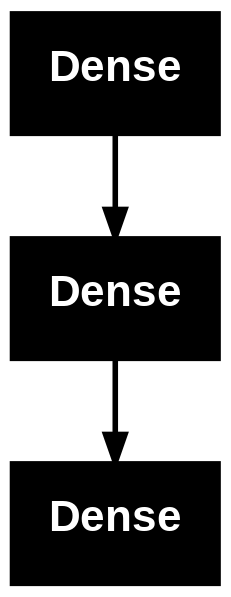

In [94]:
nn.summary()
plot_model(nn, show_shapes=False, show_layer_names=False)

## Conclusions
As we can see the model generalizes well. It doesn't overfit the training data which is shown by the fact that the results on the test set are on par with the ones from the test set. The model reached a respectable accuracy of 75%, which may not be enough in a real world scenario, however for our case study it is satisfactory.

## Model Prediction Explanations
In this section we will try to deduce what impacted the model's decision the most. We will use three benchmark patients mentioned in the Introduction section: one surely sick, one perfectly healthy and one for which it is very hard to decide on the first glance.

In [95]:
data=pd.read_csv('mammographic.csv',header=None)

In [96]:
data.columns=['BI-RADS','Age','Shape','Margin','Density','Severity']

In [97]:
data

,BI-RADS,Age,Shape,Margin,Density,Severity
0,0.090909,0.628205,0.666667,1.00,0.666667,1.0
1,0.090909,0.512821,1.000000,1.00,0.666667,1.0
2,0.072727,0.128205,0.000000,0.00,0.666667,0.0
3,0.090909,0.500000,0.000000,1.00,0.666667,1.0
4,0.090909,0.743590,0.000000,0.75,0.666667,1.0
...,...,...,...,...,...,...
825,0.072727,0.371795,0.333333,0.00,0.666667,0.0
826,0.072727,0.487179,1.000000,1.00,0.666667,1.0
827,0.072727,0.589744,1.000000,1.00,0.666667,0.0
828,0.090909,0.615385,1.000000,1.00,0.666667,1.0


### Patient ID 241 (sick patient)
As one can see the model is pretty certain that this patient has breast cancer

In [98]:
patient_sick=data.iloc[241].to_numpy()[:5].reshape(1, -1)
nn.predict(patient_sick)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


np.float32(0.58141935)

In [99]:
"healthy" if nn.predict(patient_sick)[0][0] < 0.5 else "sick"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


'sick'

### Patient ID 400 (healthy patient)
The model is very certain that the mass is not malignant, thus predicting the patient is healthy

In [100]:
patient_healthy=data.iloc[400].to_numpy()[:5].reshape(1, -1)
nn.predict(patient_healthy)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


np.float32(0.06014623)

In [101]:
"healthy" if nn.predict(patient_healthy)[0][0] < 0.5 else "sick"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


'healthy'

### Patient ID 573 (unknown patient)
Here the model is on the fence as we suspected. It suspects that the patient is healthy, however it is as close to a 50-50 as it gets.

In [102]:
patient_unknown=data.iloc[573].to_numpy()[:5].reshape(1, -1)
nn.predict(patient_unknown)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


np.float32(0.473134)

In [103]:
"healthy" if nn.predict(patient_unknown)[0][0] < 0.5 else "sick"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


'healthy'

### Which features influenced the model's decision?
We will use gradient of output with respect to input. If the gradient is negative it will decrease the output, if it is negative, it increases the predicted value.

In [104]:
def output_gradient(nn, id):
  #prepare the input
  input_tensor = tf.convert_to_tensor(data.iloc[id].to_numpy()[:5].reshape(1, -1), dtype=tf.float32)

  with tf.GradientTape() as tape:
      tape.watch(input_tensor)
      output = nn(input_tensor)

  # Compute gradients
  grad = tape.gradient(output, input_tensor)[0].numpy()
  return grad


In [105]:
def visulaize_gradient(saliency):
  feature_names = data.columns[:5]

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.bar(feature_names, saliency, color='blue')
  plt.title('Gradients per Feature')
  plt.xlabel('Features')
  plt.ylabel('Gradient')
  plt.grid(axis='y', linestyle='--', alpha=0.3)
  plt.ylim([-1, 3])
  plt.tight_layout()
  plt.show()

### Patient ID 241 (sick patient)
For the sick patient we can see that the first feature influenced the model's prediction heavily, while the Margin was the least important.

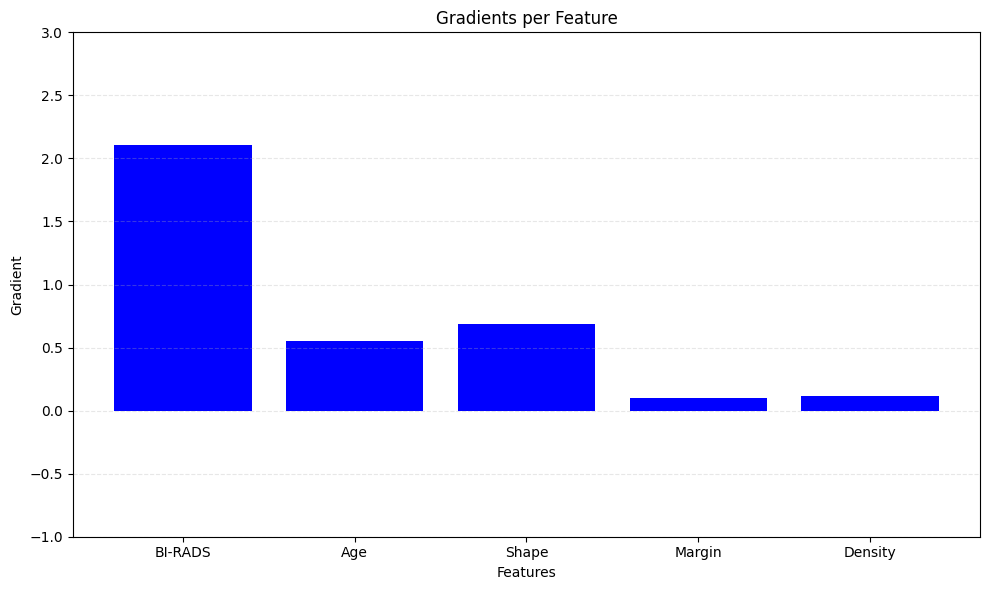

In [106]:
visulaize_gradient(output_gradient(nn,241))

### Patient ID 400 (healthy patient)
For the healthy patient we can see that all the features experienced small gradient, indicating that this example is very safe.

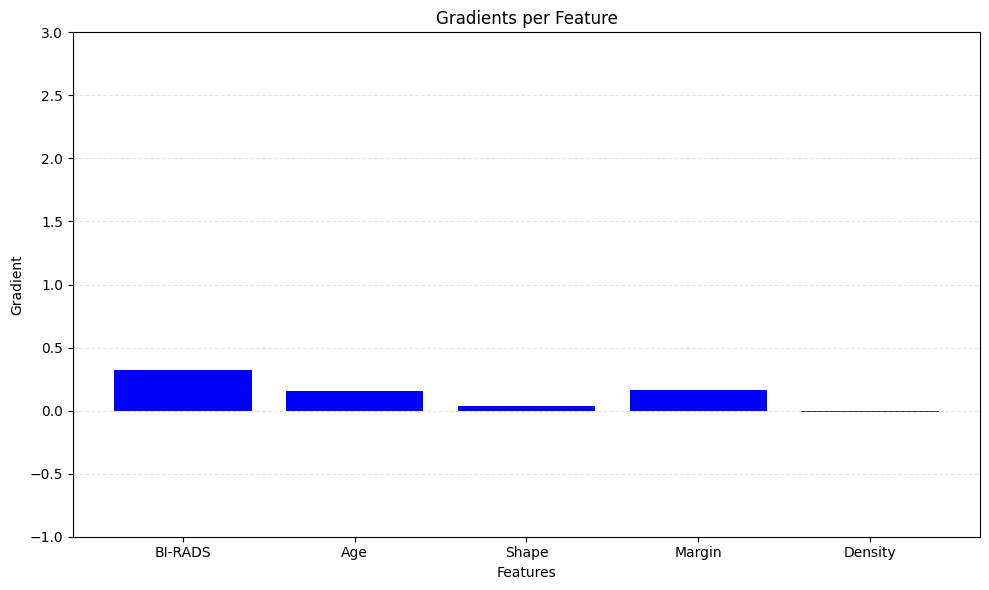

In [107]:
visulaize_gradient(output_gradient(nn,400))

### Patient ID 573 (unknown patient)
For this person again, we can see that BI-RADS feature is the most important here and Density and Shape Features are the least important.

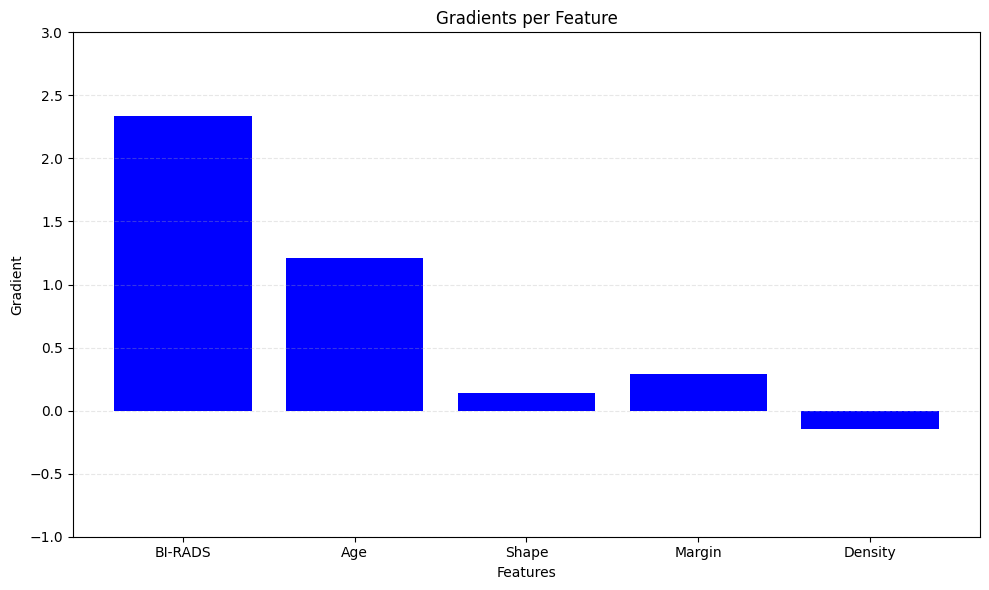

In [108]:
visulaize_gradient(output_gradient(nn,573))

## Model explainability
We will explain the model using two methods: surrogate model and permutation_feature_importance

In [109]:
X = data.drop("Severity", axis=1).values
y= data["Severity"].values

In [110]:
y_pred = (nn.predict(X)>0.5).astype("int32")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [111]:


surrogate = DecisionTreeRegressor(max_depth=3)

surrogate.fit(X, y_pred)

DecisionTreeRegressor(max_depth=3)

### R-squared metrics
According to our experiments the surrogate model explains 86% of variance of the neural network's predictions. It is a good model for trying to visualize its predictions.

In [112]:
r2 = r2_score(y_pred, surrogate.predict(X))
print(f"Surrogate R2: {r2:.2f}")

Surrogate R2: 0.86


### Decision Tree
As one can see there are a couple of pure branches in the tree. If the Margin is low, the Age feature splits the samples perfectly. Furthermore, if the person is older and the shape of the mass is irregular, the person is most likely sick. If the person is younger and the shape is not irregular the person is likely healthy.

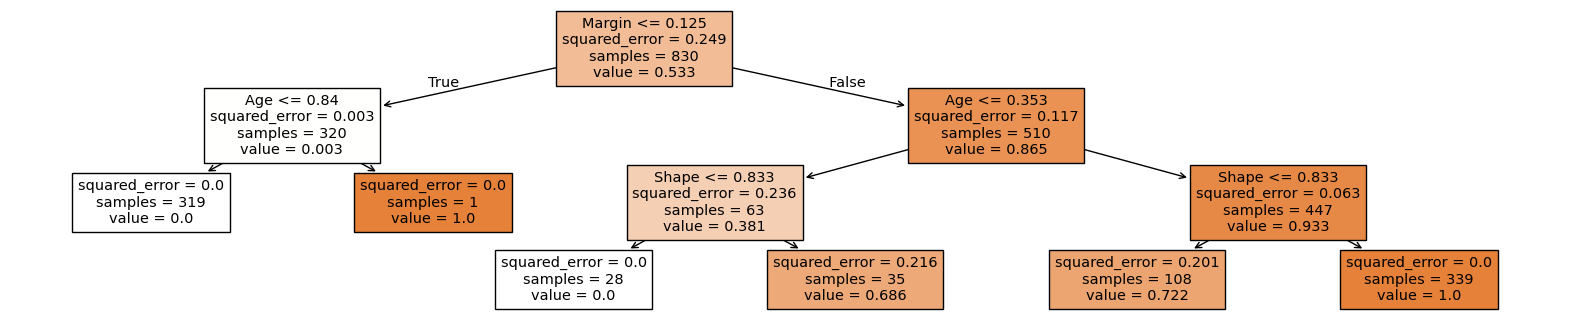

In [113]:
plt.figure(figsize=(20, 4))
plot_tree(surrogate, feature_names=data.columns[:-1], filled=True)
plt.show()


### Permutation feature importance
In this method we will shuffle one feature and leave the rest unchanged. Then, we will compare this model with the original one and see how much the accuracy dips. Probably, if some feature's removal drops the performance significantly, the feature is likely very important for prediction.

In [114]:
def plot_permutation_feature_importance(nn, X_test,data,y_test,seed):
  random.seed(seed)
  np.random.seed(seed)
  feature_names = data.columns
  importances = []

  for i in range(X_test.shape[1]):
      X_permuted = X_test.copy()
      np.random.shuffle(X_permuted[:, i])

      y_pred = nn.predict(X_permuted)
      y_pred_class = (y_pred>0.5).astype("int32")

      score = accuracy_score(y_test, y_pred_class)

      importance = accuracy - score
      importances.append(importance)
      print(f"{feature_names[i]}: {importance:.4f}")
  plt.figure(figsize=(10, 4))
  plt.bar(range(len(importances)), importances)
  plt.xticks(range(len(importances)), feature_names[:5], rotation=45)
  plt.ylabel("Permutation Importance (Accuracy Drop)")
  plt.title("Permutation Feature Importance for Neural Network")
  plt.tight_layout()
  plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
BI-RADS: 0.0088
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Age: 0.0442
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Shape: 0.0354
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Margin: 0.0619
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Density: 0.0000


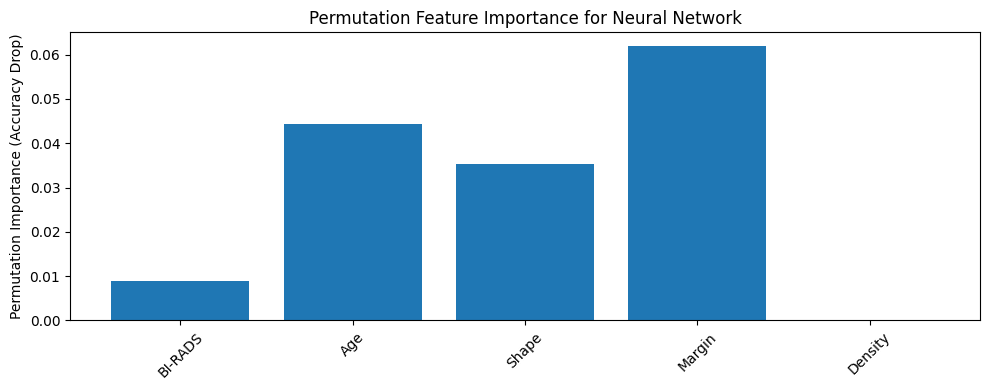

In [115]:
random.seed(1234)
plot_permutation_feature_importance(nn,X_test,data,y_test,42)

According to this method, the most important feature to maximize accuracy is Margin, with Age and Shape falling behind slightly. Bl-RADS and Density don't seem to be that important in terms of model performance.